## Poisson equation with scikit-fem

This example solves the Poisson problem using [scikit-fem](https://scikit-fem.readthedocs.io/) using data generated by Nanomesh.

It is an adaptation of [example 1](https://scikit-fem.readthedocs.io/en/latest/listofexamples.html#example-1-poisson-equation-with-unit-load).

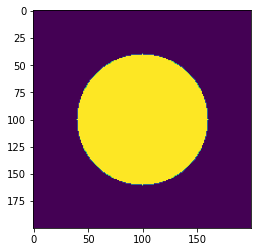

In [1]:
import numpy as np
from skimage.morphology import disk
import matplotlib.pyplot as plt

H, L = 200, 200
Hmid = int(H/2)
Lmid = int(H/2)
r = 60

data = np.zeros((H, L))
data[Hmid-r: Hmid+1+r, Lmid-r:Lmid+1+r] += disk(r)

plt.figure()
plt.imshow(data)

Generate a triangle mesh using `Nanomesh.Mesher`. The triangles that don't belong to the circle are purged.

<AxesSubplot:title={'center':'triangle mesh'}>

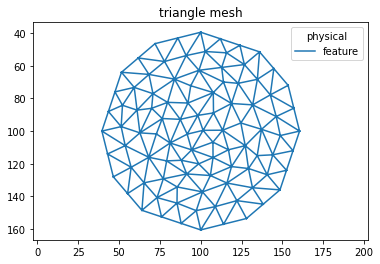

In [2]:
from nanomesh import Mesher

mesher = Mesher(data)
mesher.generate_contour(max_edge_dist=10, precision=5)
mesh = mesher.triangulate(opts='q30a100')
triangles = mesh.get('triangle')
triangles.purge(label=1, key='physical')

triangles.plot()

### Converting to a scikit-fem mesh type

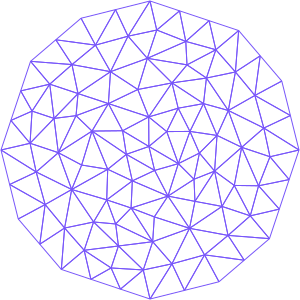

In [3]:
from skfem import MeshTri

p = triangles.points.T
t = triangles.cells.T

m = MeshTri(p, t)
m

### Setting up and solving the PDE

The following code was re-used from [here](https://github.com/kinnala/scikit-fem/blob/master/docs/examples/ex01.py).

In [4]:
from skfem import *
from skfem.helpers import dot, grad

e = ElementTriP1()

basis = Basis(m, e)

# this method could also be imported from skfem.models.laplace
@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))


# this method could also be imported from skfem.models.unit_load
@LinearForm
def rhs(v, _):
    return 1.0 * v

A = asm(laplace, basis)
b = asm(rhs, basis)
# or:
# A = laplace.assemble(basis)
# b = rhs.assemble(basis)

# enforce Dirichlet boundary conditions
A, b = enforce(A, b, D=m.boundary_nodes())

# solve -- can be anything that takes a sparse matrix and a right-hand side
x = solve(A, b)

Initializing CellBasis(MeshTri1, ElementTriP1)
Initializing finished.
Assembling 'laplace'.
Assembling finished.
Assembling 'rhs'.
Assembling finished.
Solving linear system, shape=(96, 96).
Solving done.


### Visualize the result

<AxesSubplot:>

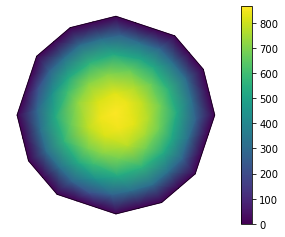

In [5]:
def visualize():
    from skfem.visuals.matplotlib import plot
    return plot(m, x, shading='gouraud', colorbar=True, ax=ax)

visualize()